# Project Outline

This project looks at the stock price of Roku. By doing a time series analysis and also a sentiment analysis on social media for the stock price of Roku we will try and predict future prices.

Project flow:
 * Gather stock price (Gathering_Data notebook)
 * Gather posts from twitter and reddit (Gathering_Data notebook)
 * Clean up and do EDA (Gathering_Data notebook)
 * Do a sentiment analysis for each day (This notebook)
 * Do a time series analysis on both stock price and sentiment individually (This notebook)
 * Combine the sentiment and stock price to try and predict future prices (This notebook)

# Importing packages and loading data

In [1]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import twint
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
import datetime as dt
import time
import re
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import pmdarima as pm
from statsmodels.graphics.gofplots import qqplot
from pmdarima.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt




pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

/Users/stevenkyle/opt/anaconda3/envs/Capstone-new/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
# Loading data
T_df = pd.read_csv('TwitterData.csv', header=None)
T_df.columns = ['id', 'date', 'timezone', 'tweet', 'language', 'cashtags', 
                'username', 'day', 'hour', 'nlikes', 'nreplies', 'nretweets', 'search']
R_df = pd.read_csv('redditdata.csv')
S_df = pd.read_csv('StockData.csv')

# Functions

In [3]:
# This function will remove emojis from the text

def RemoveEmojis(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [4]:
# This function is to run text through spacy/textblob pipeline
def Sentiment(text):
    
    #Initializing Sentiment analyzer
    SIA = SentimentIntensityAnalyzer()
    
    # Words to add to the sentiment lexicon
    new_words = {
        'bullish': 3.4,
        'bull':3.4,
        'long':3.4,
        'longs':3.4,
        'Holding':3.4,
        'holding':3.4,
        'Hodl':3.4,
        'hodl':3.4,
        'Call':3.4,
        'Calls':3.4,
        'call':3.4,
        'calls':3.4,
        'Put':-3.9,
        'Puts':-3.9,
        'put':-3.9,
        'puts':-3.9,
        'bear':-3.9,
        'bearish':-3.9,
        'short': -3.9,
        'shorts':-3.9
        }

    # Updating lexicon
    SIA.lexicon.update(new_words)
    
    # Running
    output = SIA.polarity_scores(text)
    
    return output['compound']

In [5]:
# This function will calculate the mse

def mse_calc(data, prediction, start, column):
    y_hat = prediction.predicted_mean
    real_values = data[start:][column]
    mse = ((real_values-y_hat)**2).mean()
    return mse

In [6]:
# This function will plot the timeseries and the predicted values from the model

def PlotPredictions(obs_data, pred_data, pred_data_conf, figsize=(15,8), beg='2013', title='title'):
    
    plt.figure(figsize=figsize)
    
    # Plot observed values
    ax = obs_data[beg:].plot(label='Observed')

    # Plot predicted values
    pred_data.predicted_mean.plot(ax=ax)

    # Plot the range for confidence intervals
    ax.fill_between(pred_data_conf.index,
                pred_data_conf.iloc[:, 0],
                pred_data_conf.iloc[:, 1], color='g', alpha=0.1)

    # Set axes labels
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.legend()
    plt.show()

In [7]:
# This function is used to try different sets of parameters for SARIMAX
# It will return a dataframe with the parameters and the aic values

def Grid_Auto_bot(data, order_list):

    # Initializing an empty list for storing results
    results=[]

    # Going through and creating a model using all combinations of order
    # Also outputing order/aic score to a list
    for comb in order_list:
        try:
            mod = ARIMA(data, order = comb, freq='B')
            output = mod.fit()
            results.append([comb,ARIMAResults.aic(output)])
            print('ARIMA {} : AIC Calculated ={}'.format(comb, ARIMAResults.aic(output)))
             
        except:
            continue
                
    # Creating a dataframe for the results
    ans_df = pd.DataFrame(results, columns=['pdq','aic'])
    
    # Making aic column into numeric
    ans_df['aic'] = pd.to_numeric(ans_df['aic'])
    
    return ans_df

In [8]:
# This function will do an arima model using the order that is put in and will display the
# residual diagnostics and predictions

def ArimaModelDiagnostics(data,order,pred_start):
    # Making the train ARIMA model
    Train_model = ARIMA(data,
                        order=order,
                        freq='B')
    train_output = Train_model.fit()
    
    # Shows the train model summary
    print('Train_model summary')
    display(train_output.summary());

    # Plotting the residuals for the model
    residuals = pd.DataFrame(train_output.resid)

    fig1, axes = plt.subplots(figsize=(14,8),nrows=2, ncols=2)
    fig1.tight_layout(pad=1, w_pad=2, h_pad=5)

    residuals.plot(ax=axes[0,0])
    residuals.plot(kind='kde',ax=axes[0,1])
    plot_acf(residuals, ax=axes[1,1]);
    qqplot(train_output.resid,line='s',ax=axes[1,0]);

    axes[0,0].set_title('Residuals');
    axes[0,1].set_title('KDE');
    axes[1,0].set_title('QQ-Plot');

    # Plotting the Predictions of the model
    fig2, ax = plt.subplots(figsize=(12,8))
    fig2 = train_output.plot_predict(start=pred_start,ax=ax);
    ax.set_title('Predictions of the model');
    ax.set_ylabel('Closing Price');
    ax.set_xlabel('Date');

In [9]:
def ArimaSubsetTest(data, order, test_size, plot_start, logged=False):
    # Split train data to a subset test data to see how well it predicts
    # Subset test data will be 20 days
    split = len(data) - test_size
    Train_train = data[:split]
    Train_test = data[split:]

    # Testing subset test
    model = ARIMA(Train_train, order=order)  
    fitted = model.fit()  

    # Forecast
    fc, se, conf = fitted.forecast(test_size, alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=Train_test.index)
    lower_series = pd.Series(conf[:, 0], index=Train_test.index)
    upper_series = pd.Series(conf[:, 1], index=Train_test.index)

    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(Train_train[plot_start:], label='Training')
    plt.plot(Train_test, label='Testing')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.show()

    if logged == False:
        # Get the error
        error = Train_test - fc_series
        mse = ((error)**2).mean()
        rmse = np.sqrt(mse)
        print('MSE was ', mse, 'and rmse was', rmse)

    elif logged == True:
        # Get the error
        unlog_test = np.exp(Train_test)
        unlog_fc = np.exp(fc_series)
        error = unlog_test - unlog_fc
        mse = ((error)**2).mean()
        rmse = np.sqrt(mse)
        print('MSE was ', mse, 'and rmse was', rmse)

In [10]:
# Arima final forecast for test data
def ArimaTestForecast(train, test, order, test_size, plot_start, logged=False):
    # Getting forecast for the test model
    model = ARIMA(train, order=raw_order_2)  
    fitted = model.fit()  

    # Forecast
    fc, se, conf = fitted.forecast(test_size, alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(conf[:, 0], index=test.index)
    upper_series = pd.Series(conf[:, 1], index=test.index)

    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train[plot_start:], label='Training')
    plt.plot(test, label='Testing')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.show()

    if logged == False:
        # Get the error
        error = test - fc_series
        mse = ((error)**2).mean()
        rmse = np.sqrt(mse)
        print('MSE was ', mse, 'and rmse was', rmse)

    elif logged ==True:
        # Get the error
        unlog_test = np.exp(test)
        unlog_fc = np.exp(fc_series)
        error = unlog_test - unlog_fc
        mse = ((error)**2).mean()
        rmse = np.sqrt(mse)
        print('MSE was ', mse, 'and rmse was', rmse)

# Clean up and EDA

## Clean up Twitter EDA

In [11]:
print(T_df.shape)
T_df.head()

(666, 13)


,id,date,timezone,tweet,language,cashtags,username,day,hour,nlikes,nreplies,nretweets,search
0,913765506456473600,2017-09-29 09:00:48,-500,"$1900 in 10 minutes on $ROKU, so glad the mark...",en,['roku'],eatsleepprofit,5,9,69,8,2,$ROKU
1,913841066473869313,2017-09-29 14:01:03,-500,$ROKU is already up almost 100% since its IPO....,en,['roku'],Stocktwits,5,14,40,5,23,$ROKU
2,914147418316398592,2017-09-30 10:18:23,-500,Mystified by $ROKU's IPO? @JimCramer's breakin...,en,['roku'],MadMoneyOnCNBC,6,10,29,5,11,$ROKU
3,913892627845570560,2017-09-29 17:25:56,-500,"$ROKU Long. One Ticker, a few trades. Couldve ...",en,['roku'],SmashTheBid,5,17,28,4,0,$ROKU
4,913843670872444928,2017-09-29 14:11:24,-500,Love #Pennystocks Nice Friday for my 2 account...,en,"['vcel', 'izea', 'gluu', 'roku']",EbogeyEd,5,14,24,1,3,$ROKU


In [12]:
# Making date in dataframe just the date and no time
T_df['date'] = T_df.date.apply(lambda x: x.split(' ',1)[0])

# Dropping any scraped entries that aren't english
T_df.drop(T_df[T_df['language'] != 'en'].index, inplace = True)

# Only keeping date and tweet
T_df = T_df[['date','tweet']]

In [13]:
# Removing any url links
T_df['tweet_LinkRemoved'] = T_df.tweet.apply(
    lambda x: re.sub(r'https\S+', '', x))

# Removing any emojis
T_df['tweet_Link+Emoji_Removed'] = T_df.tweet_LinkRemoved.apply(
    lambda x: RemoveEmojis(x))

# Change things to lower case
T_df['tweet_cleaned_lowercase'] = T_df['tweet_Link+Emoji_Removed'].apply(
    lambda x: " ".join(x.lower() for x in x.split()))

# Remove punctuations
T_df['tweet_cleaned_lower_NoPunct'] = T_df['tweet_cleaned_lowercase'].str.replace(
    '[^\w\s]', '')

# Remove stopwards
stop = stopwords.words('english')
T_df['tweet_FinalClean'] = T_df['tweet_cleaned_lower_NoPunct'].apply(
    lambda x: " ".join(x for x in x.split() if x not in stop))

## Clean up Reddit

In [14]:
R_df.head()

,ID,Num_Comments,Score,Subreddit,Title,Upvote_Ratio,Created,Created_utc,Self_text,Date
0,730n8l,50,113,investing,ROKU up 28% shortly after IPO,0.91,1.506640e+09,1.506611e+09,http://www.hollywoodreporter.com/news/roku-sto...,2017-09-28
1,72ztnr,0,35,stocks,9/28 Thursday Stock Market Movers & News,0.89,1.506631e+09,1.506603e+09,#Good morning traders of the r/stocks sub! Hap...,2017-09-28
2,730zps,31,26,wallstreetbets,WHEN TO SHORT ROKU,0.85,1.506643e+09,1.506614e+09,"this company does nothing new, i think 24~ SHO...",2017-09-28
3,7314h8,37,20,wallstreetbets,ROKU now listex on NASDAQ. Up 35% so far,0.95,1.506644e+09,1.506615e+09,NaN,2017-09-28
4,730jwz,33,14,wallstreetbets,"$ROKU IPO, to the moon...?",0.90,1.506639e+09,1.506610e+09,Why isn't this thing available on my POS broke...,2017-09-28


In [15]:
# The things we care about are date, subreddit, title, and self_text
R_df = R_df[['Date','Subreddit','Title','Self_text']]

# Combining the title and self text
R_df['Self_text'] = R_df['Self_text'].fillna('.')
R_df['Combined_text'] = R_df['Title'] + ' ' + R_df['Self_text']

In [16]:
# Removing any links
R_df['Combined_text_LinksRemoved'] = R_df.Combined_text.apply(
    lambda x: re.sub(r'https\S+', '', x))
R_df['Combined_text_LinksRemoved'] = R_df.Combined_text_LinksRemoved.apply(
    lambda x: re.sub(r'http\S+', '', x))

# Removing any emojis
R_df['Combined_text_Link+Emoji_Removed'] = R_df.Combined_text_LinksRemoved.apply(lambda x: RemoveEmojis(x))

# Change things to lower case
R_df['Combined_text_cleaned_lowercase'] = R_df['Combined_text_Link+Emoji_Removed'].apply(
    lambda x: " ".join(x.lower() for x in x.split()))

# Remove punctuations
R_df['Combined_text_cleaned_lower_NoPunct'] = R_df['Combined_text_cleaned_lowercase'].str.replace(
    '[^\w\s]', '')

# Remove stopwards
stop = stopwords.words('english')
R_df['Combined_text_FinalClean'] = R_df['Combined_text_cleaned_lower_NoPunct'].apply(
    lambda x: " ".join(x for x in x.split() if x not in stop))

In [17]:
R_df

,Date,Subreddit,Title,Self_text,Combined_text,Combined_text_LinksRemoved,Combined_text_Link+Emoji_Removed,Combined_text_cleaned_lowercase,Combined_text_cleaned_lower_NoPunct,Combined_text_FinalClean
0,2017-09-28,investing,ROKU up 28% shortly after IPO,http://www.hollywoodreporter.com/news/roku-sto...,ROKU up 28% shortly after IPO http://www.holly...,ROKU up 28% shortly after IPO \n\n>The video s...,ROKU up 28% shortly after IPO \n\n>The video s...,roku up 28% shortly after ipo >the video strea...,roku up 28 shortly after ipo the video streami...,roku 28 shortly ipo video streaming device mak...
1,2017-09-28,stocks,9/28 Thursday Stock Market Movers & News,#Good morning traders of the r/stocks sub! Hap...,9/28 Thursday Stock Market Movers & News #Good...,9/28 Thursday Stock Market Movers & News #Good...,9/28 Thursday Stock Market Movers & News #Good...,9/28 thursday stock market movers & news #good...,928 thursday stock market movers news good mo...,928 thursday stock market movers news good mor...
2,2017-09-28,wallstreetbets,WHEN TO SHORT ROKU,"this company does nothing new, i think 24~ SHO...",WHEN TO SHORT ROKU this company does nothing n...,WHEN TO SHORT ROKU this company does nothing n...,WHEN TO SHORT ROKU this company does nothing n...,when to short roku this company does nothing n...,when to short roku this company does nothing n...,short roku company nothing new think 24 short ...
3,2017-09-28,wallstreetbets,ROKU now listex on NASDAQ. Up 35% so far,.,ROKU now listex on NASDAQ. Up 35% so far .,ROKU now listex on NASDAQ. Up 35% so far .,ROKU now listex on NASDAQ. Up 35% so far .,roku now listex on nasdaq. up 35% so far .,roku now listex on nasdaq up 35 so far,roku listex nasdaq 35 far
4,2017-09-28,wallstreetbets,"$ROKU IPO, to the moon...?",Why isn't this thing available on my POS broke...,"$ROKU IPO, to the moon...? Why isn't this thin...","$ROKU IPO, to the moon...? Why isn't this thin...","$ROKU IPO, to the moon...? Why isn't this thin...","$roku ipo, to the moon...? why isn't this thin...",roku ipo to the moon why isnt this thing avail...,roku ipo moon isnt thing available pos brokers
...,...,...,...,...,...,...,...,...,...,...
613,2021-05-11,wallstreetbets,"$FUBO - Archegos, Misreported Earnings, and th...",Reporting AH ( 45 mins ) so i dont have much t...,"$FUBO - Archegos, Misreported Earnings, and th...","$FUBO - Archegos, Misreported Earnings, and th...","$FUBO - Archegos, Misreported Earnings, and th...","$fubo - archegos, misreported earnings, and th...",fubo archegos misreported earnings and the qu...,fubo archegos misreported earnings quiet perio...
614,2021-05-12,investing,Best Dip Stocks to buy right now,"Hey y'all,\n\nI have alot of cash lying around...","Best Dip Stocks to buy right now Hey y'all,\n\...","Best Dip Stocks to buy right now Hey y'all,\n\...","Best Dip Stocks to buy right now Hey y'all,\n\...","best dip stocks to buy right now hey y'all, i ...",best dip stocks to buy right now hey yall i ha...,best dip stocks buy right hey yall alot cash l...
615,2021-05-13,Daytrading,"The Only Watch List You Need May 13, 2021",*The original Gap Watch List Poster! The one t...,"The Only Watch List You Need May 13, 2021 *The...","The Only Watch List You Need May 13, 2021 *The...","The Only Watch List You Need May 13, 2021 *The...","the only watch list you need may 13, 2021 *the...",the only watch list you need may 13 2021 the o...,watch list need may 13 2021 original gap watch...
616,2021-05-20,wallstreetbets,PUBM DD #1,\n\nA little bit about myself for context:\n\...,PUBM DD #1 \n\nA little bit about myself for ...,PUBM DD #1 \n\nA little bit about myself for ...,PUBM DD #1 \n\nA little bit about myself for ...,pubm dd #1 a little bit about myself for conte...,pubm dd 1 a little bit about myself for contex...,pubm dd 1 little bit context 1 work enterprise...


In [18]:
R_df.iloc[0]['Combined_text_LinksRemoved']

'ROKU up 28% shortly after IPO \n\n>The video streaming device maker had late Wednesday set its initial public offering price at $14 per share, or a market value of $1.3 billion.\n\n>The stock of video streaming device maker Roku rose in its stock market debut on Thursday. It opened just after 10:35 a.m. ET at $15.78, up 12.7 percent.\n\n>About 10 minutes later, it was up 28 percent at $17.94.\n\n>The company had recently filed for an initial public offering and late Wednesday had set its IPO price at $14 per share, which raised about $219 million and made for a market value of $1.3 billion.\n\n>The  Los Gatos, Calif.-based company, which makes TV set-top boxes and other devices, listed its stock on the Nasdaq under the ticker symbol ROKU. Its filing have shown that Roku lost $42.8 million in 2016 on nearly $399 million in revenue, up 25 percent from 2015.\n\n>Roku, led by CEO Anthony Wood, has also disclosed that its users streamed more than 6.7 billion hours of programming on its pla

# Exploring sentiment analysis, Vader

In [19]:
# Figuring out the max and min of the scores in the lexicon
SIA = SentimentIntensityAnalyzer()

maxi = 0
mini = 0

for k,v in SIA.lexicon.items():

    if v > maxi:
        maxi = v
    if v < mini:
        mini = v
        
print('Maximum points for a word/emoticon', maxi)
print('Minimum points for a word/emoticon', mini)

Maximum points for a word/emoticon 3.4
Minimum points for a word/emoticon -3.9


Added custom words with scores as either the maximum or minimum in the Sentiment Function located earlier in the notebook. Vader can take in emoji's, going to try a tweet examples with an emoji and without the emojis to see which one is more accurate.

In [20]:
# Tweet with the links removed
T_df.iloc[0]['tweet_LinkRemoved']

"$1900 in 10 minutes on $ROKU, so glad the market is picking up with multiple runners literally everyday. I really hope this doesn't stop🙏🏼😁  "

In [21]:
print('Score with the emoji: ',Sentiment(T_df.iloc[0]['tweet_LinkRemoved']))
print('Score without the emoji: ',Sentiment(T_df.iloc[0]['tweet_Link+Emoji_Removed']))

Score with the emoji:  0.8989
Score without the emoji:  0.838


It looks like the tweet with the emoji is more accurate, for future sentiment analysis the emoji's will be used in the text.

# Combining Reddit and Twitter Data

In [22]:
T_df.head()

,date,tweet,tweet_LinkRemoved,tweet_Link+Emoji_Removed,tweet_cleaned_lowercase,tweet_cleaned_lower_NoPunct,tweet_FinalClean
0,2017-09-29,"$1900 in 10 minutes on $ROKU, so glad the mark...","$1900 in 10 minutes on $ROKU, so glad the mark...","$1900 in 10 minutes on $ROKU, so glad the mark...","$1900 in 10 minutes on $roku, so glad the mark...",1900 in 10 minutes on roku so glad the market ...,1900 10 minutes roku glad market picking multi...
1,2017-09-29,$ROKU is already up almost 100% since its IPO....,$ROKU is already up almost 100% since its IPO....,$ROKU is already up almost 100% since its IPO....,$roku is already up almost 100% since its ipo....,roku is already up almost 100 since its ipo he...,roku already almost 100 since ipo heres went p...
2,2017-09-30,Mystified by $ROKU's IPO? @JimCramer's breakin...,Mystified by $ROKU's IPO? @JimCramer's breakin...,Mystified by $ROKU's IPO? @JimCramer's breakin...,mystified by $roku's ipo? @jimcramer's breakin...,mystified by rokus ipo jimcramers breaking it ...,mystified rokus ipo jimcramers breaking
3,2017-09-29,"$ROKU Long. One Ticker, a few trades. Couldve ...","$ROKU Long. One Ticker, a few trades. Couldve ...","$ROKU Long. One Ticker, a few trades. Couldve ...","$roku long. one ticker, a few trades. couldve ...",roku long one ticker a few trades couldve done...,roku long one ticker trades couldve done lot b...
4,2017-09-29,Love #Pennystocks Nice Friday for my 2 account...,Love #Pennystocks Nice Friday for my 2 account...,Love #Pennystocks Nice Friday for my 2 account...,love #pennystocks nice friday for my 2 account...,love pennystocks nice friday for my 2 accounts...,love pennystocks nice friday 2 accounts 1200 v...


In [23]:
R_df.head()

,Date,Subreddit,Title,Self_text,Combined_text,Combined_text_LinksRemoved,Combined_text_Link+Emoji_Removed,Combined_text_cleaned_lowercase,Combined_text_cleaned_lower_NoPunct,Combined_text_FinalClean
0,2017-09-28,investing,ROKU up 28% shortly after IPO,http://www.hollywoodreporter.com/news/roku-sto...,ROKU up 28% shortly after IPO http://www.holly...,ROKU up 28% shortly after IPO \n\n>The video s...,ROKU up 28% shortly after IPO \n\n>The video s...,roku up 28% shortly after ipo >the video strea...,roku up 28 shortly after ipo the video streami...,roku 28 shortly ipo video streaming device mak...
1,2017-09-28,stocks,9/28 Thursday Stock Market Movers & News,#Good morning traders of the r/stocks sub! Hap...,9/28 Thursday Stock Market Movers & News #Good...,9/28 Thursday Stock Market Movers & News #Good...,9/28 Thursday Stock Market Movers & News #Good...,9/28 thursday stock market movers & news #good...,928 thursday stock market movers news good mo...,928 thursday stock market movers news good mor...
2,2017-09-28,wallstreetbets,WHEN TO SHORT ROKU,"this company does nothing new, i think 24~ SHO...",WHEN TO SHORT ROKU this company does nothing n...,WHEN TO SHORT ROKU this company does nothing n...,WHEN TO SHORT ROKU this company does nothing n...,when to short roku this company does nothing n...,when to short roku this company does nothing n...,short roku company nothing new think 24 short ...
3,2017-09-28,wallstreetbets,ROKU now listex on NASDAQ. Up 35% so far,.,ROKU now listex on NASDAQ. Up 35% so far .,ROKU now listex on NASDAQ. Up 35% so far .,ROKU now listex on NASDAQ. Up 35% so far .,roku now listex on nasdaq. up 35% so far .,roku now listex on nasdaq up 35 so far,roku listex nasdaq 35 far
4,2017-09-28,wallstreetbets,"$ROKU IPO, to the moon...?",Why isn't this thing available on my POS broke...,"$ROKU IPO, to the moon...? Why isn't this thin...","$ROKU IPO, to the moon...? Why isn't this thin...","$ROKU IPO, to the moon...? Why isn't this thin...","$roku ipo, to the moon...? why isn't this thin...",roku ipo to the moon why isnt this thing avail...,roku ipo moon isnt thing available pos brokers


In [24]:
# Combining the Twitter dataframe and the Reddit Dataframe
temp_T_df = T_df[['date','tweet_LinkRemoved']].copy()
temp_T_df.columns = ['Date','Text']

temp_R_df = R_df[['Date','Combined_text_LinksRemoved']].copy()
temp_R_df.columns = ['Date','Text']

Sentiment_df = pd.concat([temp_T_df,temp_R_df])

In [25]:
print('Check to see if combination worked.')
print('Twitter dataframe number of entries: ', len(T_df))
print('Reddit dataframe number of entries: ', len(R_df))
print('Combined dataframe number of entries: ', len(Sentiment_df))

Check to see if combination worked.
Twitter dataframe number of entries:  565
Reddit dataframe number of entries:  618
Combined dataframe number of entries:  1183


# Running the sentiment function to find sentiment scores

In [26]:
Sentiment_df['Score'] = Sentiment_df.Text.apply(lambda x: Sentiment(x))

In [27]:
Sentiment_df

,Date,Text,Score
0,2017-09-29,"$1900 in 10 minutes on $ROKU, so glad the mark...",0.8989
1,2017-09-29,$ROKU is already up almost 100% since its IPO....,0.0000
2,2017-09-30,Mystified by $ROKU's IPO? @JimCramer's breakin...,0.0000
3,2017-09-29,"$ROKU Long. One Ticker, a few trades. Couldve ...",0.5647
4,2017-09-29,Love #Pennystocks Nice Friday for my 2 account...,0.9222
...,...,...,...
613,2021-05-11,"$FUBO - Archegos, Misreported Earnings, and th...",0.8991
614,2021-05-12,"Best Dip Stocks to buy right now Hey y'all,\n\...",0.9050
615,2021-05-13,"The Only Watch List You Need May 13, 2021 *The...",0.9868
616,2021-05-20,PUBM DD #1 \n\nA little bit about myself for ...,0.9992


In [28]:
Text_to_check = Sentiment_df[Sentiment_df['Score'] == 0]
Text_to_check

,Date,Text,Score
1,2017-09-29,$ROKU is already up almost 100% since its IPO....,0.0
2,2017-09-30,Mystified by $ROKU's IPO? @JimCramer's breakin...,0.0
15,2017-12-08,$ROKU Next week there will be a big storm in S...,0.0
23,2017-12-22,First time since after $ROKU earnings in Nov n...,0.0
24,2017-12-30,"Oh, what a year. 📈 #BestOf2017 stocks from IB...",0.0
...,...,...,...
478,2020-12-01,$ROKU I can’t quit you .,0.0
502,2020-12-24,"Finally upgraded to the next leve(nio, Roku, e...",0.0
512,2021-01-05,Quibi Selling Catalog To Roku: Report .,0.0
531,2021-01-20,$NFLX $DIS $ROKU Streaming Services Comparison...,0.0


In [29]:
print('Texts from ',len(Text_to_check),' had a sentiment score of 0 (they analyzer did not understand or they were neutral).')
print('That is ', len(Text_to_check)/len(Sentiment_df)*100,'% of the entries we have.')

Texts from  173  had a sentiment score of 0 (they analyzer did not understand or they were neutral).
That is  14.623837700760777 % of the entries we have.


# Combining the scores for each day and combining all data to one dataframe

In [30]:
Sentiment_df.head()

,Date,Text,Score
0,2017-09-29,"$1900 in 10 minutes on $ROKU, so glad the mark...",0.8989
1,2017-09-29,$ROKU is already up almost 100% since its IPO....,0.0000
2,2017-09-30,Mystified by $ROKU's IPO? @JimCramer's breakin...,0.0000
3,2017-09-29,"$ROKU Long. One Ticker, a few trades. Couldve ...",0.5647
4,2017-09-29,Love #Pennystocks Nice Friday for my 2 account...,0.9222


In [31]:
Avg_Sentiment_df = Sentiment_df.groupby(['Date']).mean()

In [32]:
Avg_Sentiment_df.head()

,Score
Date,
2017-09-28,0.185700
2017-09-29,0.457833
2017-09-30,0.000000
2017-10-02,-0.094050
2017-10-05,-0.011300


In [33]:
len(Avg_Sentiment_df)

519

In [34]:
len(S_df)

923

In [35]:
S_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-09-28,15.800000,23.500000,15.750000,23.500000,23.500000,39265900
1,2017-09-29,26.740000,29.799999,25.469999,26.540001,26.540001,44294700
2,2017-10-02,25.200001,26.280001,23.260000,23.559999,23.559999,16008400
3,2017-10-03,23.010000,23.020000,20.770000,20.809999,20.809999,13678500
4,2017-10-04,21.290001,22.600000,20.820000,20.850000,20.850000,9345700


In [36]:
S_df_closing = S_df[['Date','Close']]
S_df_closing.head()

,Date,Close
0,2017-09-28,23.500000
1,2017-09-29,26.540001
2,2017-10-02,23.559999
3,2017-10-03,20.809999
4,2017-10-04,20.850000


In [37]:
Final_df = pd.merge(left=S_df_closing, right=Avg_Sentiment_df, how='left', left_on='Date', right_on='Date')
Final_df.columns = ['Date','Close','Sentiment_Score']
Final_df['Date'] = pd.to_datetime(Final_df['Date'])
Final_df.set_index('Date', inplace=True)
Final_df = Final_df.asfreq('B', method='ffill')
Final_df

,Close,Sentiment_Score
Date,,
2017-09-28,23.500000,0.185700
2017-09-29,26.540001,0.457833
2017-10-02,23.559999,-0.094050
2017-10-03,20.809999,NaN
2017-10-04,20.850000,NaN
...,...,...
2021-05-24,347.220001,NaN
2021-05-25,345.700012,0.986600
2021-05-26,348.989990,NaN


In [38]:
Final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 957 entries, 2017-09-28 to 2021-05-28
Freq: B
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Close            957 non-null    float64
 1   Sentiment_Score  449 non-null    float64
dtypes: float64(2)
memory usage: 22.4 KB


In [39]:
Final_df.Close.isna().sum()

0

In [40]:
Final_df.head(75)

,Close,Sentiment_Score
Date,,
2017-09-28,23.500000,0.185700
2017-09-29,26.540001,0.457833
2017-10-02,23.559999,-0.094050
2017-10-03,20.809999,NaN
2017-10-04,20.850000,NaN
2017-10-05,22.010000,-0.011300
2017-10-06,23.200001,NaN
2017-10-09,24.540001,-0.938800
2017-10-10,22.930000,0.000000


Going to fill missing sentiment data by taking a gradient from last known sentiment to the next known sentiment.

In [41]:
Final_df['Sentiment_Score_LinearFill'] = Final_df['Sentiment_Score'].interpolate(method='linear')

In [42]:
# Making a logged closing cost since the data will most likely follow an exponential trend
Final_df['Close_logged'] = np.log(Final_df['Close'])

In [43]:
Final_df.tail(5)

,Close,Sentiment_Score,Sentiment_Score_LinearFill,Close_logged
Date,,,,
2021-05-24,347.220001,NaN,0.624075,5.849959
2021-05-25,345.700012,0.9866,0.986600,5.845571
2021-05-26,348.989990,NaN,0.789500,5.855043
2021-05-27,349.029999,NaN,0.592400,5.855158
2021-05-28,346.709991,0.3953,0.395300,5.848489


# Time series analysis for Stock Data

## Train test split, looking at original plot

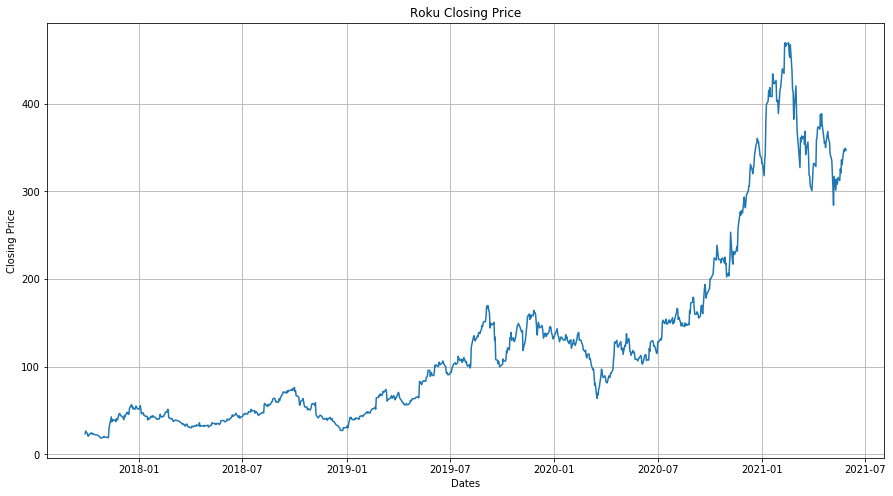

In [44]:
plt.figure(figsize = (15,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Price')
plt.plot(Final_df['Close'])
plt.title('Roku Closing Price')
plt.show()

In [45]:
# Train Test Split (Making testing data the last month)
Train, Test = train_test_split(Final_df, test_size=20)

In [46]:
Test

,Close,Sentiment_Score,Sentiment_Score_LinearFill,Close_logged
Date,,,,
2021-05-03,335.309998,0.99640,0.996400,5.815055
2021-05-04,319.589996,NaN,0.626367,5.767039
2021-05-05,304.170013,NaN,0.256333,5.717587
2021-05-06,284.179993,-0.11370,-0.113700,5.649608
2021-05-07,317.000000,0.20215,0.202150,5.758902
2021-05-10,301.410004,NaN,0.550625,5.708471
2021-05-11,314.119995,0.89910,0.899100,5.749775
2021-05-12,308.029999,0.90500,0.905000,5.730197
2021-05-13,309.600006,0.87210,0.872100,5.735281


In [47]:
print('Train set has', len(Train),'entries.')
print('Test set has', len(Test),'entries.')

Train set has 937 entries.
Test set has 20 entries.


## Looking at seasonality using Seasonal Decompose

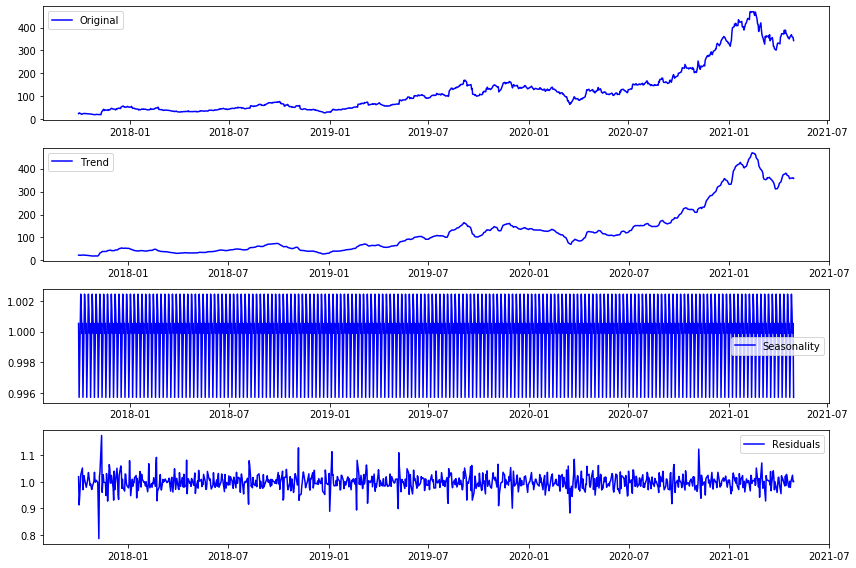

In [48]:
# Taking the decomposition of Roku Stock, the original plot sugests a multiplicative trend.
decomposition = seasonal_decompose(Train['Close'], model='multiplicative')

# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plotting the original data
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(Train['Close'], label='Original', color='blue')
plt.legend(loc='best')

# Plotting the Trend of the data
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')

# Plotting the Seasonality of the data
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')

# Plotting the Residuals of the data
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

In [49]:
seasonal

Date
2017-09-28    1.000537
2017-09-29    0.995737
2017-10-02    1.002436
2017-10-03    1.001399
2017-10-04    0.999890
                ...   
2021-04-26    1.002436
2021-04-27    1.001399
2021-04-28    0.999890
2021-04-29    1.000537
2021-04-30    0.995737
Freq: B, Name: Close, Length: 937, dtype: float64

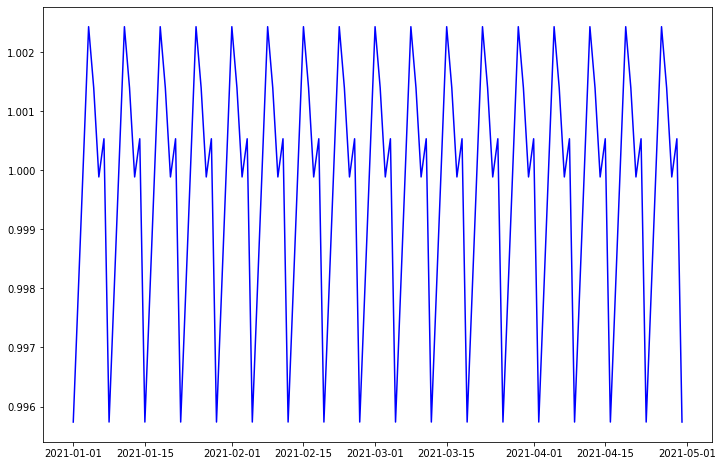

In [50]:
# Zoom up on seasonal trends
plt.figure(figsize=(12,8))
plt.plot(seasonal['2021':], label='Original', color='blue')
plt.show()

The time difference between the two minimums is 7 days 00:00:00


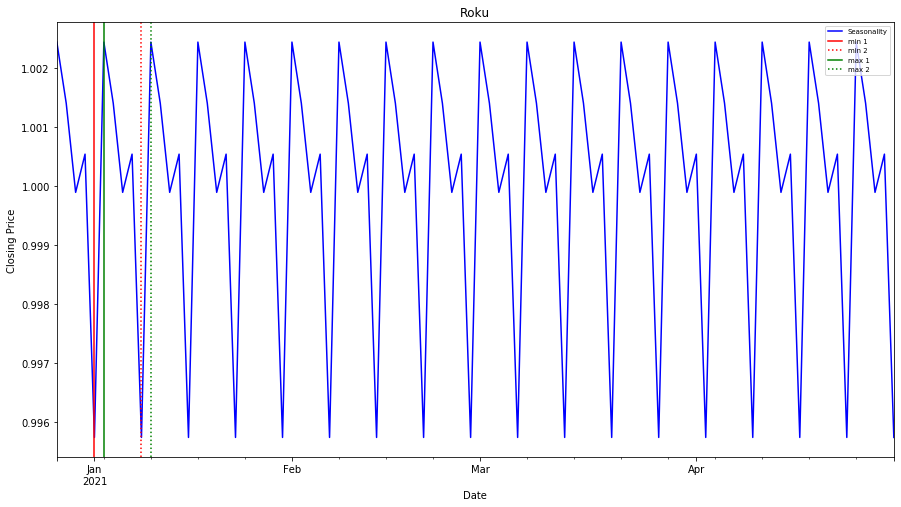

In [51]:
# Looking at the seasonal plot closer
plt.figure(figsize=(15,8))

# Plotting the seasonality plot
ax = seasonal['2020-12-27':].plot(label='Seasonality', color='blue')

# Finding the time stamps of the mins and maxs
min_ = seasonal['2021':].idxmin()
max_ = seasonal['2021':].idxmax()
min_2 = seasonal[max_:].idxmin()
max_2 = seasonal[min_2:].idxmax()

# Adding verticle lines for the mins/maxs
ax.axvline(min_,label='min 1',c='red')
ax.axvline(min_2,label='min 2',c='red', ls=':')
ax.axvline(max_,label='max 1',c='green')
ax.axvline(max_2,label='max 2',c='green', ls=':')

# Graph properties
plt.legend(loc='upper right', fontsize='x-small')
plt.xlabel('Date')
plt.title('Roku')
plt.ylabel('Closing Price')

print(f'The time difference between the two minimums is {min_2-min_}')

The seasonality seems to happen every week, however the change in price is very miniscule. The seasonality factor can most likely be ignored.

## Arima Modeling

### Auto Arima on raw data

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6142.864, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6142.815, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6143.040, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6143.501, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6141.762, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=6136.444, Time=0.21 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=6138.434, Time=0.25 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6138.441, Time=0.44 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6140.681, Time=0.47 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=6139.613, Time=0.91 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=6136.553, Time=0.08 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Total fit time: 3.010 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  937
Model:               SARIMAX(3, 1, 0)   Log Likelihood               -3063.222
Date:                Tue, 22 Jun 2021   AIC                           6136.444
Time:                        21:05:14   BIC                           6160.652
Sample:                             0   HQIC                          6145.674
                                - 937                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3063      0.211      1.451      0.147      -0.107       0.720
ar.L1         -0.0492      0.017     -2.886      0.004      -0.083      -0.016
ar.L2          0.0611      0.019      3.212      0.001       0.024       0.098
ar.L3          0.0884      0.020      4.526      0.000       0.050       0.127
sigma2        40.7459      0.871     46.758      0.000      39.038      42.454
===================================================================================
Ljung-Box (Q):                       67.95   Jarque-Bera (JB):              2367.20
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              17.84   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

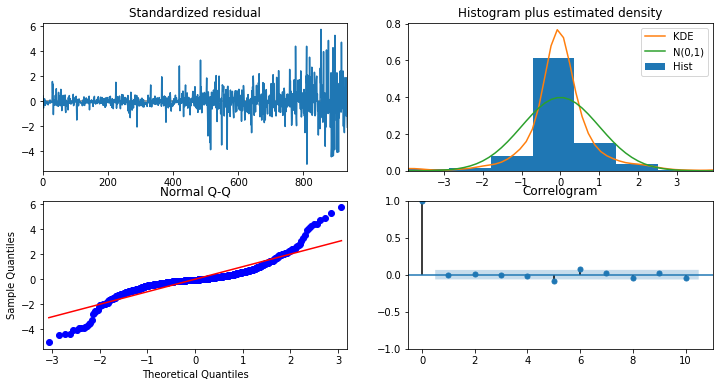

In [52]:
# Running auto_arima
auto_model = pm.auto_arima(y=Train['Close'], start_p=0, start_q=0, max_p=5, max_q=5, m=1,
                           seasonal=False, max_order=None,trace=True)

# Plotting auto_arima summary
display(auto_model.summary())

# Plotting auto_arima diagnostics
auto_model.plot_diagnostics(figsize=(12,6));

### Auto Arima on logged data

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2984.643, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2982.971, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2982.927, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2983.454, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2982.851, Time=0.61 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.330 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  937
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1494.322
Date:                Tue, 22 Jun 2021   AIC                          -2984.643
Time:                        21:05:16   BIC                          -2974.960
Sample:                             0   HQIC                         -2980.951
                                - 937                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0029      0.002      1.736      0.083      -0.000       0.006
sigma2         0.0024    4.5e-05     53.435      0.000       0.002       0.002
===================================================================================
Ljung-Box (Q):                       27.94   Jarque-Bera (JB):              4775.07
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                             0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

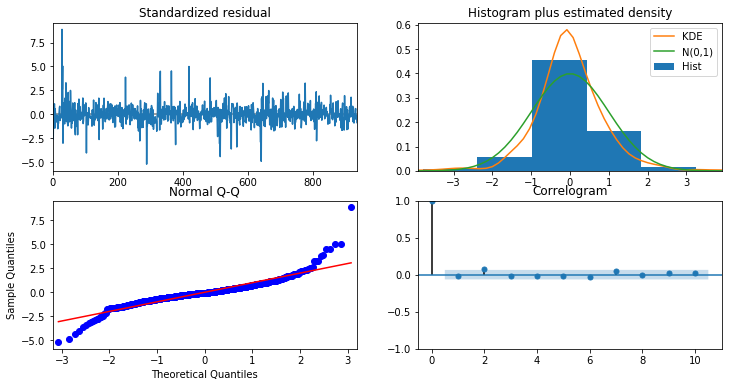

In [53]:
# Running auto_arima
auto_model = pm.auto_arima(y=Train['Close_logged'], start_p=0, start_q=0, max_p=5, max_q=5, m=1,
                           seasonal=False, max_order=None,trace=True)

# Plotting auto_arima summary
display(auto_model.summary())

# Plotting auto_arima diagnostics
auto_model.plot_diagnostics(figsize=(12,6));

The scores of the AIC look very close together, to further investigate we're going to check the parameters manually.

### Checking stationarity with diff 1 on raw and logged data.

In [54]:
# Taking a difference of one on raw data
Train_Close_diff1 = Train['Close'].diff(1).dropna()

print("Results of dickey fuller test for raw data")
adft = adfuller(Train_Close_diff1, autolag='AIC')

output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
for key,values in adft[4].items():
    output['critical value (%s)'%key] =  values
print(output)

Results of dickey fuller test for raw data
Test Statistics               -1.178547e+01
p-value                        1.011275e-21
No. of lags used               5.000000e+00
Number of observations used    9.300000e+02
critical value (1%)           -3.437401e+00
critical value (5%)           -2.864653e+00
critical value (10%)          -2.568427e+00
dtype: float64


In [55]:
# Taking a difference of one on logged data
Train_Close_logged_diff1 = Train['Close_logged'].diff(1).dropna()

print("Results of dickey fuller test for logged data")
adft = adfuller(Train_Close_logged_diff1, autolag='AIC')

output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
for key,values in adft[4].items():
    output['critical value (%s)'%key] =  values
print(output)

Results of dickey fuller test for logged data
Test Statistics                -20.074593
p-value                          0.000000
No. of lags used                 1.000000
Number of observations used    934.000000
critical value (1%)             -3.437371
critical value (5%)             -2.864639
critical value (10%)            -2.568420
dtype: float64


A difference of 1 will makes both time series stationary.

### PACF and ACF plots

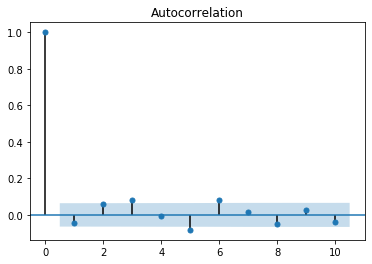

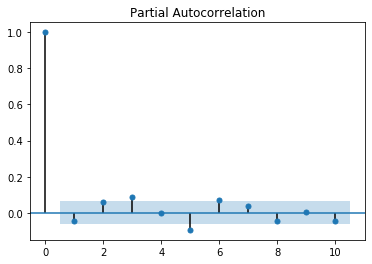

In [56]:
plot_acf(Train_Close_diff1, lags=10);
plot_pacf(Train_Close_diff1, lags=10);

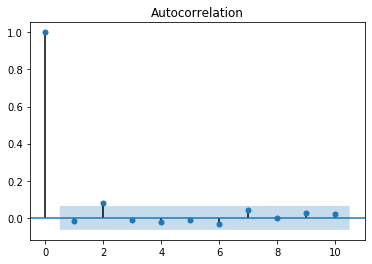

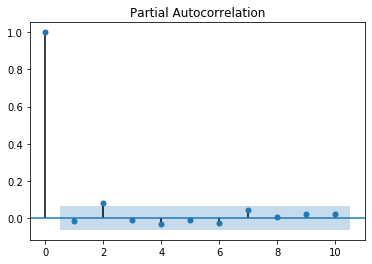

In [57]:
plot_acf(Train_Close_logged_diff1, lags=10);
plot_pacf(Train_Close_logged_diff1, lags=10);

### Trying order list found from PACF and ACF

In [58]:
# Trying different sets of parameters on raw data
order_list = [(0,1,0),(3,1,0),(0,1,3),(3,1,3)]

possible_params = Grid_Auto_bot(data = Train['Close'], order_list=order_list)
print('This is for the raw data')

# Ordering the parameters by aic
possible_params.sort_values(by='aic', ascending=True, inplace=True)
raw_order_1 = possible_params.iloc[0]['pdq']
raw_order_2 = possible_params.iloc[1]['pdq']
possible_params.head()

ARIMA (0, 1, 0) : AIC Calculated =6142.863782328211
ARIMA (3, 1, 0) : AIC Calculated =6136.4440438694455
ARIMA (0, 1, 3) : AIC Calculated =6135.733400260092
ARIMA (3, 1, 3) : AIC Calculated =6133.331174900932
This is for the raw data


,pdq,aic
3,"(3, 1, 3)",6133.331175
2,"(0, 1, 3)",6135.733400
1,"(3, 1, 0)",6136.444044
0,"(0, 1, 0)",6142.863782


In [59]:
# Trying different set of params on logged data
order_list = [(0,1,0),(2,1,0),(0,1,2),(2,1,2)]

possible_params = Grid_Auto_bot(data = Train['Close_logged'], order_list=order_list)
print('This is for the logged data')

# Ordering the parameters by aic
possible_params.sort_values(by='aic', ascending=True, inplace=True)
logged_order_1 = possible_params.iloc[0]['pdq']
logged_order_2 = possible_params.iloc[1]['pdq']
possible_params.head()

ARIMA (0, 1, 0) : AIC Calculated =-2984.643006506342
ARIMA (2, 1, 0) : AIC Calculated =-2986.8492037374563
ARIMA (0, 1, 2) : AIC Calculated =-2987.13229670313
ARIMA (2, 1, 2) : AIC Calculated =-2983.3539719715036
This is for the logged data


,pdq,aic
2,"(0, 1, 2)",-2987.132297
1,"(2, 1, 0)",-2986.849204
0,"(0, 1, 0)",-2984.643007
3,"(2, 1, 2)",-2983.353972


### Modeling using the new parameters

#### RAW DATA

##### First Parameter

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                  936
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -3058.666
Method:                       css-mle   S.D. of innovations              6.352
Date:                Tue, 22 Jun 2021   AIC                           6133.331
Time:                        21:05:20   BIC                           6172.064
Sample:                    09-29-2017   HQIC                          6148.100
                         - 04-30-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3396      0.224      1.515      0.130      -0.100       0.779
ar.L1.D.Close    -0.0106      0.335     -0.032      0.975      -0.666       0.645
ar.L2.D.Close    -0.4824      0.156     -3.099      0.002      -0.787      -0.177
ar.L3.D.Close     0.2299      0.254      0.905      0.366      -0.268       0.728
ma.L1.D.Close    -0.0353      0.339     -0.104      0.917      -0.699       0.629
ma.L2.D.Close     0.5499      0.153      3.587      0.000       0.249       0.850
ma.L3.D.Close    -0.1509      0.264     -0.571      0.568      -0.668       0.367
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.3050           -1.2301j            1.2674           -0.2887
AR.2           -0.3050           +1.2301j            1.2674            0.2887
AR.3            2.7085           -0.0000j            2.7085           -0.0000
MA.1           -0.1779           -1.2748j            1.2872           -0.2721
MA.2           -0.1779           +1.2748j            1.2872            0.2721
MA.3            4.0004           -0.0000j            4.0004           -0.0000
-----------------------------------------------------------------------------
"""

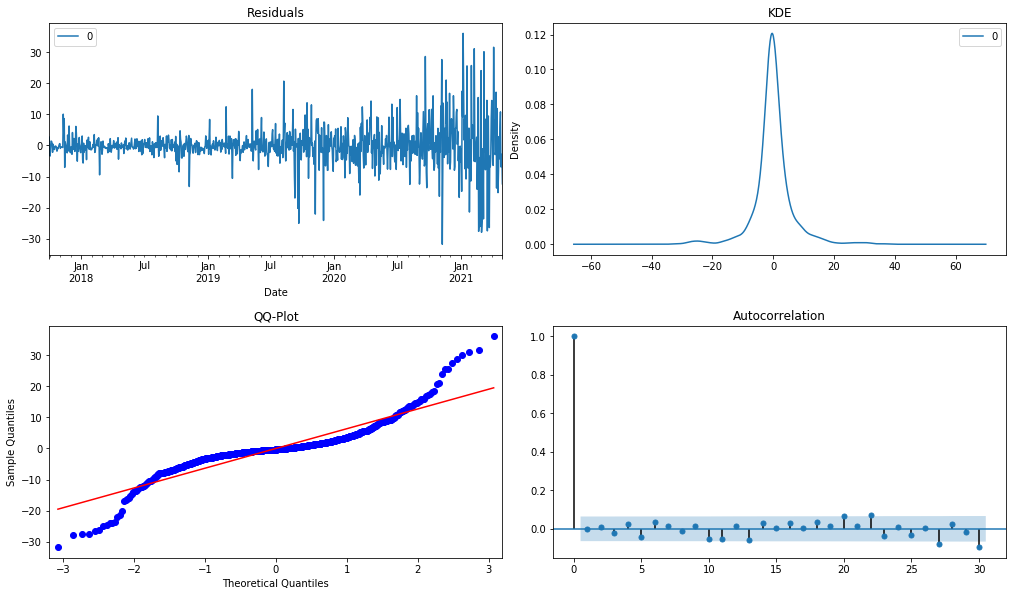

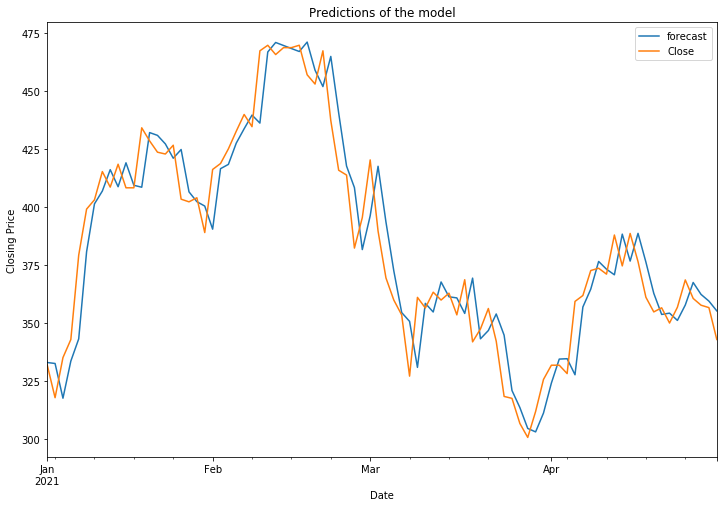

In [60]:
# Testing the First set of parameters
ArimaModelDiagnostics(Train['Close'], order=raw_order_1, pred_start='2021-01-01')

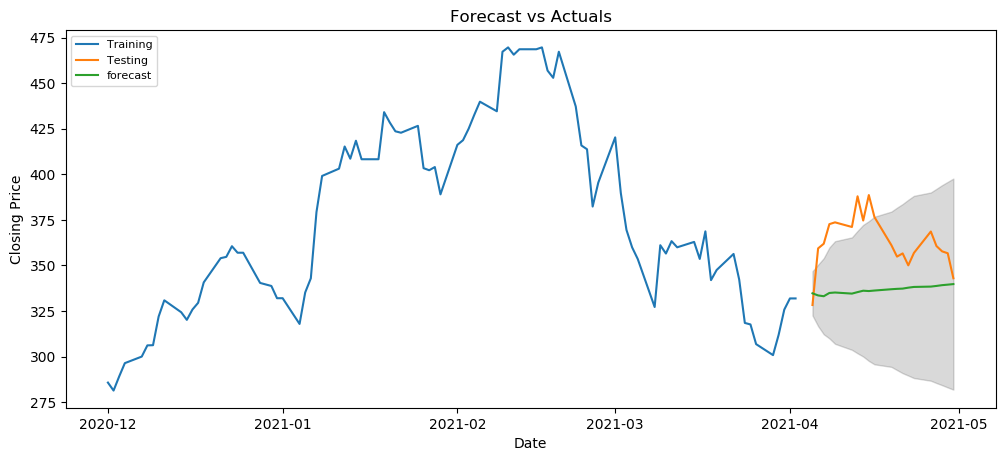

MSE was  912.5501110648231 and rmse was 30.20844436684589


In [61]:
ArimaSubsetTest(Train['Close'], order=raw_order_1, test_size=20, plot_start='2020-12-01')

##### Second Parameter

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                  936
Model:                 ARIMA(0, 1, 3)   Log Likelihood               -3062.867
Method:                       css-mle   S.D. of innovations              6.381
Date:                Tue, 22 Jun 2021   AIC                           6135.733
Time:                        21:05:22   BIC                           6159.941
Sample:                    09-29-2017   HQIC                          6144.964
                         - 04-30-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3384      0.232      1.457      0.145      -0.117       0.794
ma.L1.D.Close    -0.0458      0.033     -1.404      0.161      -0.110       0.018
ma.L2.D.Close     0.0800      0.034      2.349      0.019       0.013       0.147
ma.L3.D.Close     0.0797      0.030      2.614      0.009       0.020       0.139
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            0.9001           -1.9141j            2.1152           -0.1800
MA.2            0.9001           +1.9141j            2.1152            0.1800
MA.3           -2.8043           -0.0000j            2.8043           -0.5000
-----------------------------------------------------------------------------
"""

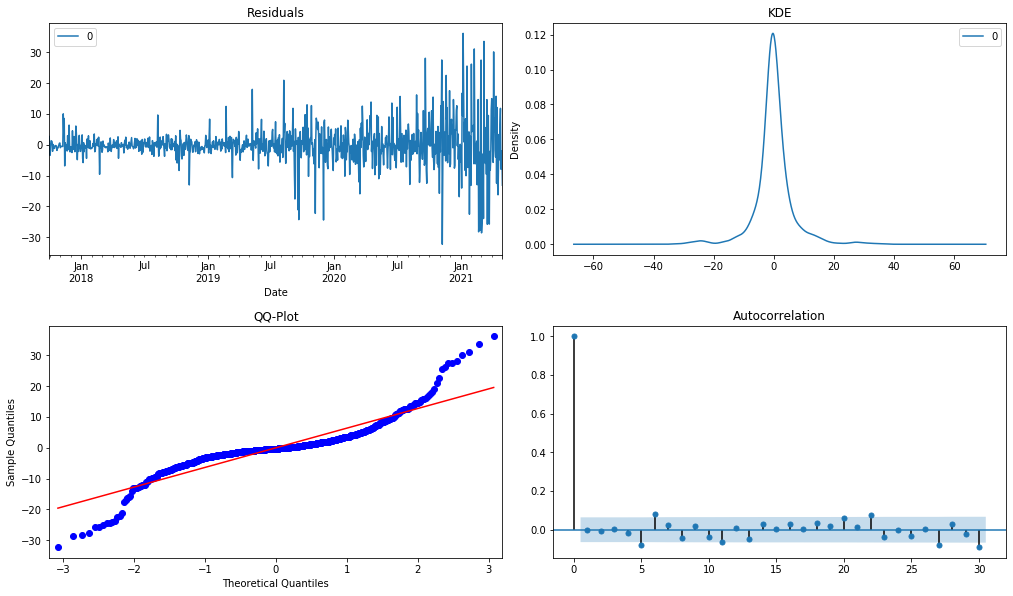

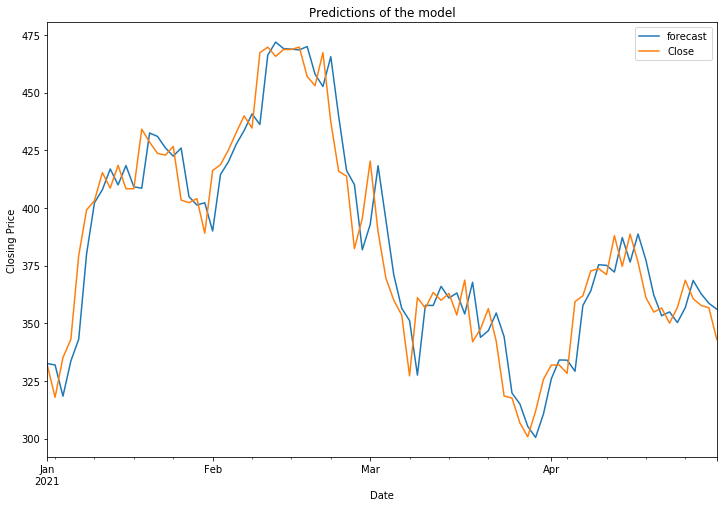

In [62]:
# Testing the Second set of parameters
ArimaModelDiagnostics(Train['Close'], order=raw_order_2, pred_start='2021-01-01')

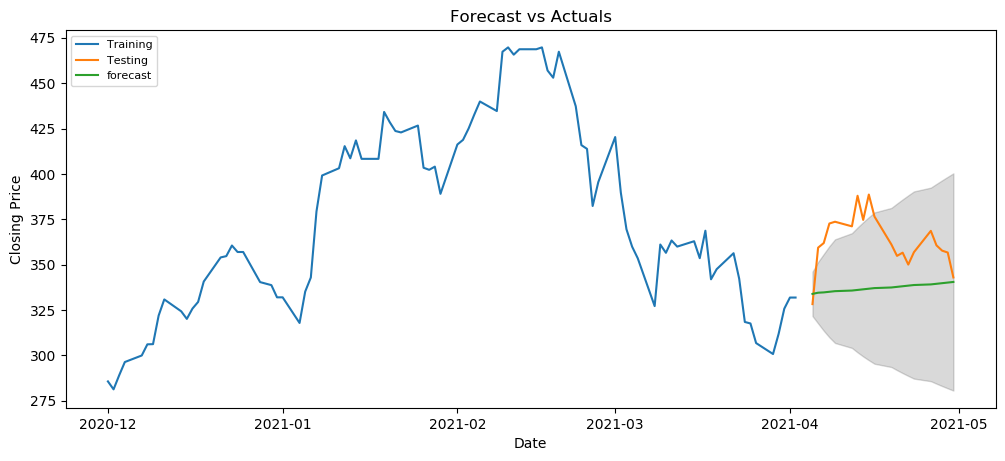

MSE was  874.2468035342654 and rmse was 29.567664830592648


In [63]:
ArimaSubsetTest(Train['Close'], order=raw_order_2, test_size=20, plot_start='2020-12-01')

##### Final Model, test predictions

The parameters that will be used is the second parameter. The difference between the two parameters are miniscule but the second parameter is a little simpler and also had slightly less error.

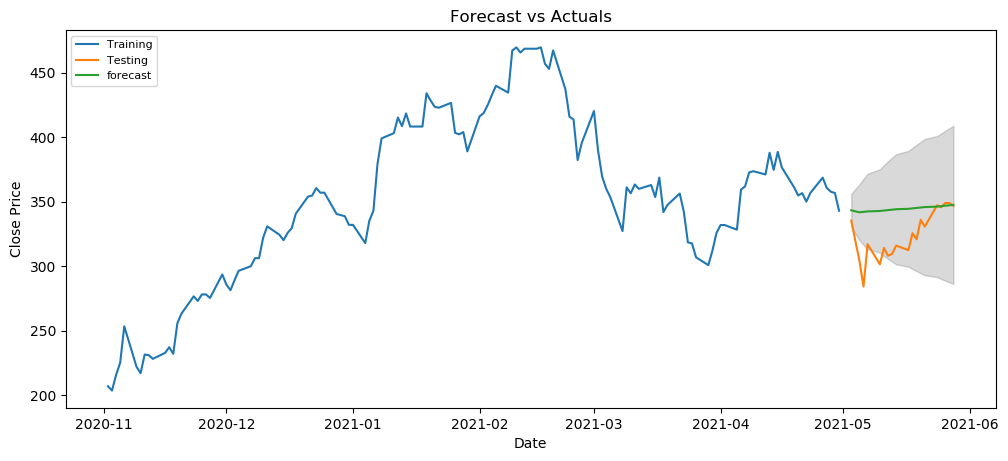

MSE was  705.3375501054053 and rmse was 26.558191770250573


In [64]:
ArimaTestForecast(train=Train['Close'], test=Test['Close'], 
                  order=raw_order_2, test_size=20, plot_start='2020-11-01', logged=False)

#### LOGGED DATA

##### First Parameter

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.Close_logged   No. Observations:                  936
Model:                 ARIMA(0, 1, 2)   Log Likelihood                1497.566
Method:                       css-mle   S.D. of innovations              0.049
Date:                Tue, 22 Jun 2021   AIC                          -2987.132
Time:                        21:05:25   BIC                          -2967.766
Sample:                    09-29-2017   HQIC                         -2979.748
                         - 04-30-2021                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0029      0.002      1.677      0.094      -0.000       0.006
ma.L1.D.Close_logged    -0.0165      0.033     -0.506      0.613      -0.081       0.047
ma.L2.D.Close_logged     0.0839      0.033      2.509      0.012       0.018       0.149
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            0.0984           -3.4512j            3.4526           -0.2455
MA.2            0.0984           +3.4512j            3.4526            0.2455
-----------------------------------------------------------------------------
"""

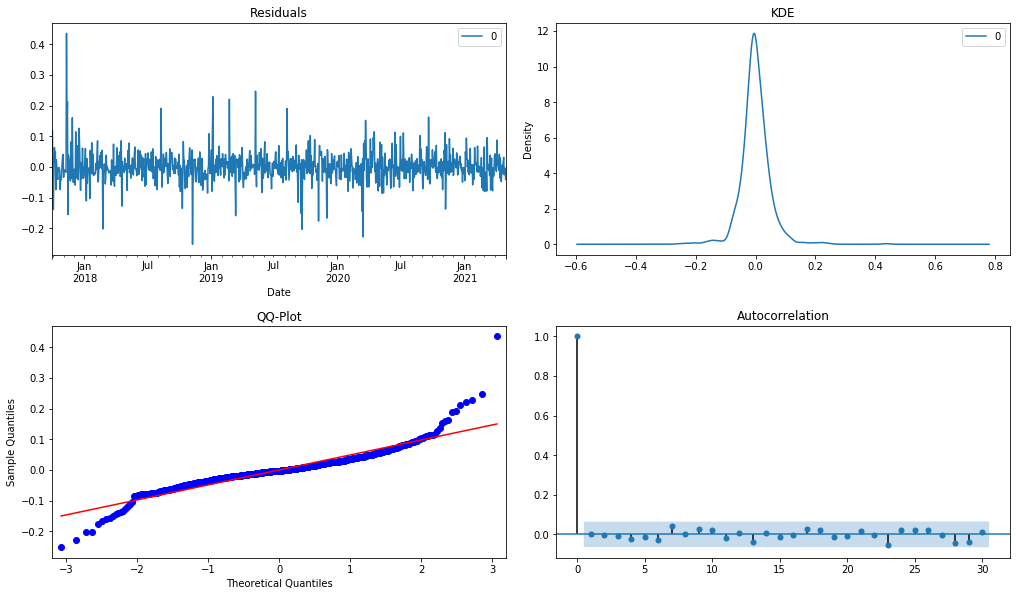

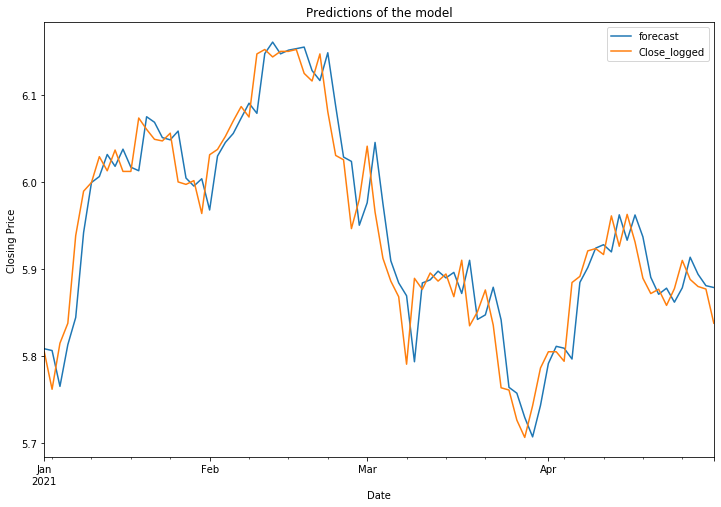

In [65]:
# Testing the First set of parameters
ArimaModelDiagnostics(Train['Close_logged'], order=logged_order_1, pred_start='2021-01-01')

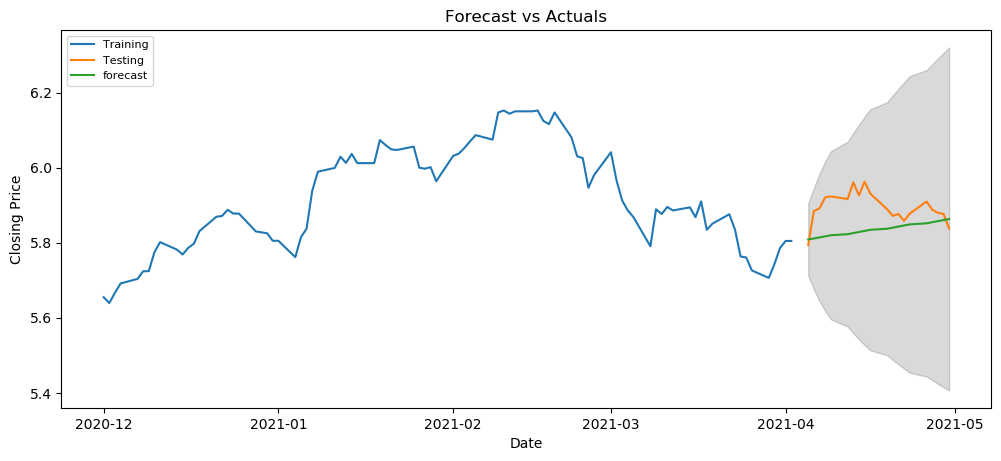

MSE was  686.9214628247762 and rmse was 26.209186611277662


In [66]:
ArimaSubsetTest(Train['Close_logged'], order=logged_order_1, test_size=20,
                plot_start='2020-12-01', logged=True)

##### Second Parameter

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.Close_logged   No. Observations:                  936
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1497.425
Method:                       css-mle   S.D. of innovations              0.049
Date:                Tue, 22 Jun 2021   AIC                          -2986.849
Time:                        21:05:27   BIC                          -2967.483
Sample:                    09-29-2017   HQIC                         -2979.465
                         - 04-30-2021                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0029      0.002      1.679      0.093      -0.000       0.006
ar.L1.D.Close_logged    -0.0178      0.033     -0.545      0.586      -0.082       0.046
ar.L2.D.Close_logged     0.0796      0.033      2.428      0.015       0.015       0.144
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.4349           +0.0000j            3.4349            0.5000
AR.2            3.6586           +0.0000j            3.6586            0.0000
-----------------------------------------------------------------------------
"""

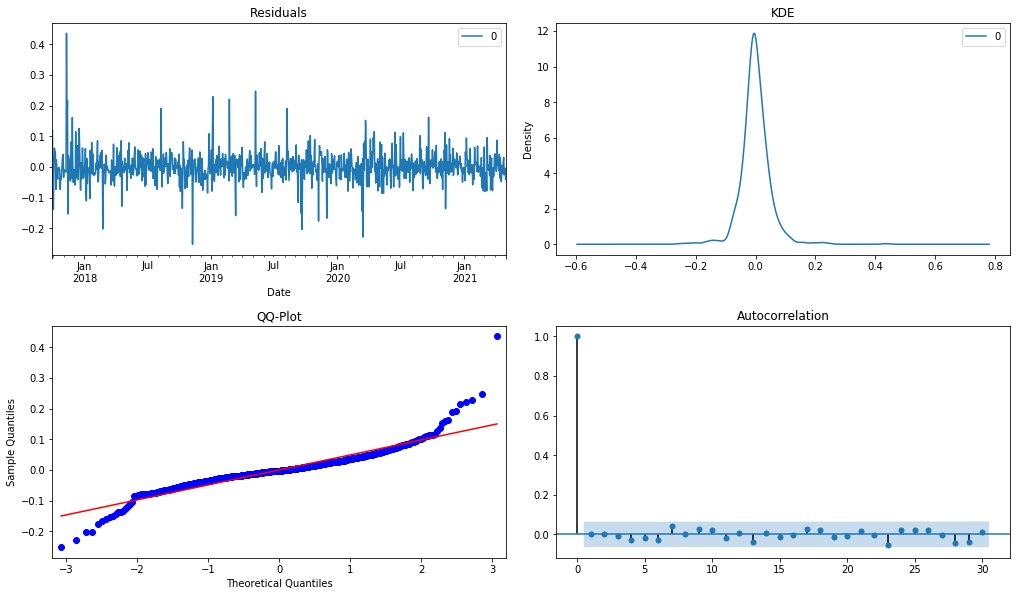

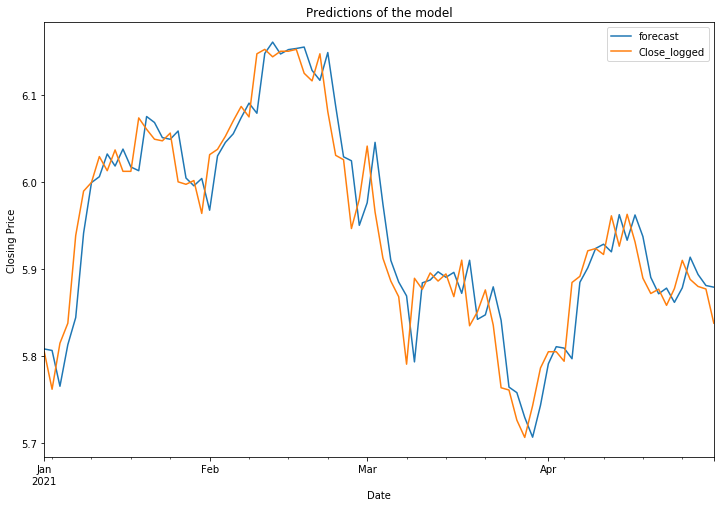

In [67]:
# Testing the Second set of parameters
ArimaModelDiagnostics(Train['Close_logged'], order=logged_order_2, pred_start='2021-01-01')

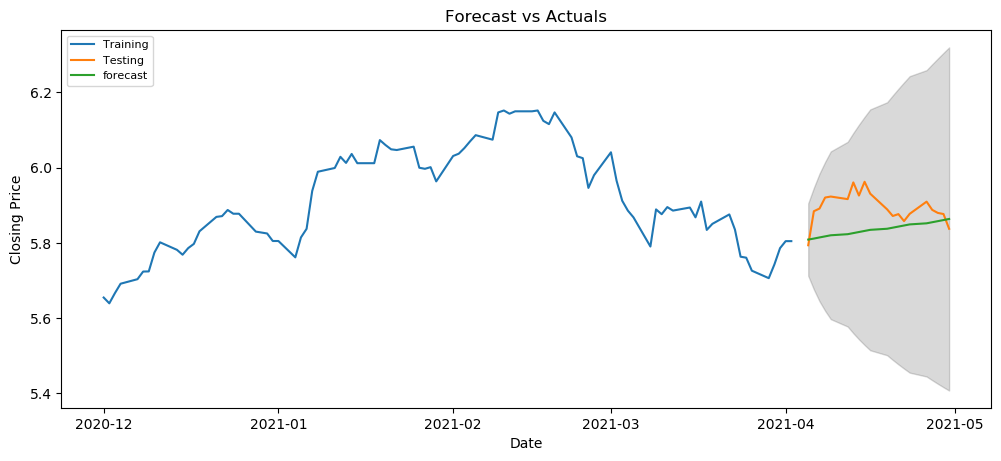

MSE was  680.8478480612446 and rmse was 26.09306130106708


In [68]:
ArimaSubsetTest(Train['Close_logged'], order=logged_order_2, test_size=20,
                plot_start='2020-12-01', logged=True)

##### Final Model, test predictions

Going with the second parameters, the difference wasn't that great and the error rate was less for the second parameter.

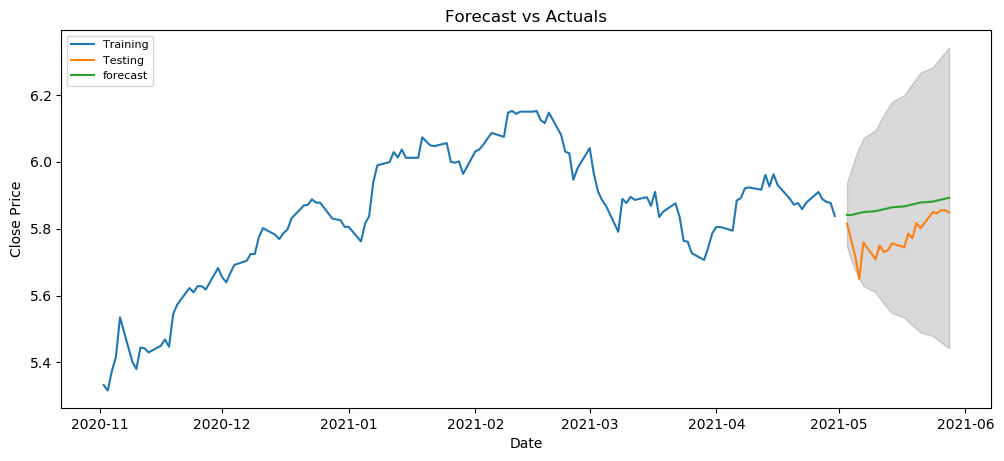

MSE was  1041.1354370530955 and rmse was 32.26663039508612


In [69]:
ArimaTestForecast(train=Train['Close_logged'], test=Test['Close_logged'], 
                  order=raw_order_2, test_size=20, plot_start='2020-11-01', logged=True)

## LSTM Modeling Single Step

### Non Stationary testing

In [70]:
# Creating supervised learning set for LSTM
Supervised_LSTM_Data = pd.DataFrame(Final_df['Close'])
Supervised_LSTM_Data['Shifted_Close'] = Supervised_LSTM_Data['Close'].shift(1)
Supervised_LSTM_Data.fillna(0, inplace=True)
Supervised_LSTM_Data.columns = ['Y','X']
Supervised_LSTM_Data = Supervised_LSTM_Data[['X','Y']]
Supervised_LSTM_Data.head()

,X,Y
Date,,
2017-09-28,0.000000,23.500000
2017-09-29,23.500000,26.540001
2017-10-02,26.540001,23.559999
2017-10-03,23.559999,20.809999
2017-10-04,20.809999,20.850000


In [71]:
# Train test split, the test size is the latest 20 days in the data that was collected
Supervised_LSTM_Data_Values = Supervised_LSTM_Data.values
train, test = Supervised_LSTM_Data_Values[0:-20], Supervised_LSTM_Data_Values[-20:]
print('Training shape:',train.shape)
print('Testing shape:', test.shape)

Training shape: (937, 2)
Testing shape: (20, 2)


In [72]:
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled


In [73]:
# Scaling the train and test set so that it is between -1 and 1
scaler, train_scaled, test_scaled = scale(train, test)

In [74]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(
                   batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
        print('Still Running')
    return model

In [75]:
# Making initial model
trial_model = fit_lstm(train=train_scaled, batch_size=1, nb_epoch=100 ,neurons=4)

Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still 

In [76]:
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [77]:
# Predicting train data
train_reshaped = train[:, 0].reshape(len(train), 1, 1)
trial_model.predict(train_reshaped, batch_size=1)

array([[-0.16460995],
       [ 0.5781722 ],
       [ 0.7038203 ],
       [ 0.72235334],
       [ 0.724892  ],
       [ 0.7252362 ],
       [ 0.7252828 ],
       [ 0.7252891 ],
       [ 0.7252898 ],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0.72529006],
       [ 0

In [78]:
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [79]:
# The raw closing costs
raw_values = Final_df['Close']

In [80]:
# One step forecast for this LSTM
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(trial_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    # yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i ]
    print('Days=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Days=1, Predicted=351.094573, Expected=335.309998
Days=2, Predicted=351.309702, Expected=319.589996
Days=3, Predicted=328.817489, Expected=304.170013
Days=4, Predicted=312.316244, Expected=284.179993
Days=5, Predicted=292.346727, Expected=317.000000
Days=6, Predicted=327.941323, Expected=301.410004
Days=7, Predicted=308.275903, Expected=314.119995
Days=8, Predicted=322.030028, Expected=308.029999
Days=9, Predicted=315.112746, Expected=309.600006
Days=10, Predicted=317.147040, Expected=315.950012
Days=11, Predicted=323.375966, Expected=312.429993
Days=12, Predicted=319.572494, Expected=325.529999
Days=13, Predicted=332.442132, Expected=320.839996
Days=14, Predicted=326.906469, Expected=335.980011
Days=15, Predicted=341.615224, Expected=330.649994
Days=16, Predicted=335.172634, Expected=347.220001
Days=17, Predicted=351.189587, Expected=345.700012
Days=18, Predicted=347.822195, Expected=348.989990
Days=19, Predicted=351.278873, Expected=349.029999
Days=20, Predicted=350.987540, Expected=

Test RMSE: 15.685


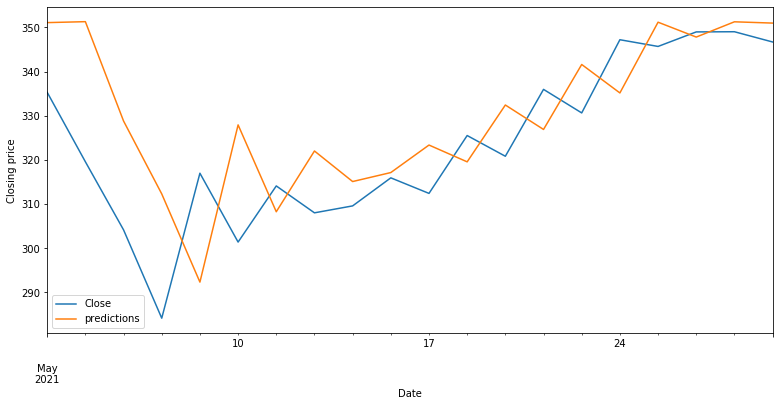

In [106]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-20:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
temp_df = pd.DataFrame(raw_values[-20:])
temp_df['predictions'] = predictions
temp_df.plot(legend=True, figsize=(13,6))
plt.ylabel('Closing price')
plt.show()

### Stationary testing

# Testing

In [ ]:
# Order of things to do

# Look at rolling average
# autoarima DONE
# Check stationarity DONE
# Check pacf and acf curves DONE
# Try manual params DONE
# Check manual params on train set, include pictures DONE
# Use manual params on test set, include pictures DONE
# LSTM Modeling Nonstationary DONE
# LSTM Modeling Stationary
# LSTM Tuning?
# LSTM Modeling using both sentiment and time series